In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from tqdm import tqdm

import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from PIL import Image
from skimage.transform import resize
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

import xgboost as xgb

# import efficientnet for feature extraction 
from efficientnet_pytorch import EfficientNet

In [2]:
# Device configuration (GPU can be enabled in settings)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
print(device)

cuda:0


In [4]:
# upload train dataframe
train_df_allsamples = pd.read_csv("../TrainTestDataFrames/marking.csv")
train_df_allsamples.head()
path = "../../data-512/512x512-dataset-melanoma/512x512-dataset-melanoma/"

In [5]:
# create dictionary that maps image name to target 
image_names = train_df_allsamples["image_id"].values 
targets = train_df_allsamples["target"].values
img_to_target = {image_name:target for image_name, target in zip(image_names, targets)}

percent_tp = sum(targets)/len(targets) * 100 
print("{} training samples total.".format(len(targets)))
print("Only {:.3f} percent of training data set is a true positive.".format(percent_tp))
print("Therefore, the baseline accuracy is {:.3f}".format(np.max([percent_tp, 100-percent_tp])))

60487 training samples total.
Only 9.058 percent of training data set is a true positive.
Therefore, the baseline accuracy is 90.942


In [6]:
# update so that the number of positives balances negatives
train_df_pos = train_df_allsamples.iloc[targets>0, :]
train_df_neg = train_df_allsamples.iloc[targets==0, :]
train_df_negsample = train_df_neg.sample(n=int(train_df_pos.shape[0]))

# concatenate negative and positive samples, then shuffle using .sample() 
#train_val_df = pd.concat((train_df_pos, train_df_negsample)).sample(frac=1)
train_val_df = train_df_allsamples.sample(frac=1)

train_val_split = .975
n_train_val = train_val_df.shape[0]
n_train = int(train_val_split*n_train_val)

train_df = train_val_df[:n_train]
val_df = train_val_df[n_train:]

# create dictionary that maps image name to target 
image_names = val_df["image_id"].values 
val_targets = val_df["target"].values

percent_tp = sum(val_targets)/len(val_targets) * 100 
baseline = np.max([percent_tp, 100-percent_tp])

print("{} Training and {} Validation samples".format(n_train, n_train_val-n_train))
print("{:.3f} percent of validation data set is a positive.".format(percent_tp))
print("Baseline validation accuracy is {:.3f}".format(baseline))

58974 Training and 1513 Validation samples
9.914 percent of validation data set is a positive.
Baseline validation accuracy is 90.086


In [4]:
# import efficientnet model 
model = EfficientNet.from_pretrained('efficientnet-b0').to(device)

Loaded pretrained weights for efficientnet-b0


In [7]:
meta_features = ['sex', 'age_approx', 'anatom_site_general_challenge'] 

encoder = {}
for feature in meta_features: 
    # determine unique features  
    categories = np.unique(np.array(train_df[feature].values, str))
    for i, category in enumerate(categories): 
        if category != 'nan':
            encoder[category] = np.float(i)
encoder['nan'] = np.nan

transform = transforms.Compose([
    transforms.RandomResizedCrop(size=256, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, path_to_files):
        # 1. Initialize file paths or a list of file names.
        self.path = path_to_files
        self.df = df

    def __getitem__(self, index):
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).
        
        # load X 
        img_name = self.df['image_id'].values[index]
        img_path = self.path + img_name + ".jpg"
        img = plt.imread(img_path)
        
        # determine meta data 
        meta = self.df[meta_features].values[index]
        meta_data = np.array([encoder[str(m)] for m in meta])
        
        # load y 
        label = self.df["target"].values[index]
        target = torch.tensor(label, dtype=torch.float32)
        
        # 2. Preprocess the data (e.g. torchvision.Transform).
        img = Image.fromarray(img)
        #img = img.resize((256, 256))
        img_processed = transform(img)
        # 3. Return a data pair (e.g. image and label).
        return img_processed, meta_data, target
        
    def __len__(self):
        # total size of your dataset.
        return self.df.shape[0]

In [6]:
# Use the data loader.
batch_size = 16

train_dataset = Dataset(train_df, path)                                              
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size)   

model = model.eval()
for i, (images, meta_data, labels) in tqdm(enumerate(train_loader)):
    images = images.to(device)

    # Forward pass
    embed = model(images)
    embedding = embed.detach().cpu().numpy()

    # determine NN features for the set of images 
    batch_features = np.concatenate((embedding, meta_data.numpy()), axis=1)
    
    # append the dataset
    try:
        X = np.concatenate((X, batch_features), 0)
        y = np.append(y, labels.numpy())
    except:
        X = batch_features 
        y = labels.numpy() 


'\n# Use the data loader.\nbatch_size = 8\n\ntrain_dataset = Dataset(train_df, path)                                              \ntrain_loader = torch.utils.data.DataLoader(dataset=train_dataset, \n                                           batch_size=batch_size)   \n\nmodel = model.eval()\nfor i, (images, meta_data, labels) in tqdm(enumerate(train_loader)):\n    images = images.to(device)\n\n    # Forward pass\n    embed = model(images)\n    embedding = embed.detach().cpu().numpy()\n\n    # determine NN features for the set of images \n    batch_features = np.concatenate((embedding, meta_data.numpy()), axis=1)\n    \n    # append the dataset\n    try:\n        X = np.concatenate((X, batch_features), 0)\n        y = np.append(y, labels.numpy())\n    except:\n        X = batch_features \n        y = labels.numpy() \n'

In [20]:
# Empty GPU cache 
torch.cuda.empty_cache()

# Save X and y in pandas dataframe 
XGB_data = pd.DataFrame(data=X)
XGB_data['targets'] = y 
XGB_data.to_csv("XGB_ENet_train.csv", index=False)
#XGB_data = pd.read_csv("XGB_ENet_train.csv")

X = np.array(XGB_data.values[:, :-1], np.float32) 
y = np.array(XGB_data['targets'].values, np.float32)

In [8]:
# weight positive examples more heavily 
def make_weights(targets, nclasses=2):   
    count = [0] * nclasses                                                      
    for label in targets:                                                         
        count[np.int(label)] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(targets)                                              
    for idx, label in enumerate(targets):                                          
        weight[idx] = weight_per_class[np.int(label)]                                  
    return np.array(weight)

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=21)

# weight positive examples more heavily 
w = make_weights(y_train)

dtrain = xgb.DMatrix(X_train, label=y_train, weight=w)
dval = xgb.DMatrix(X_val, label=y_val) 

# booster params 
param = {'max_depth': 16, 'eta': .05, 'objective': 'binary:logistic'}
param['nthread'] = 16
param['eval_metric'] = 'auc'
param['subsample'] = .75
#param['gpu_id'] = 0
#param['tree_method'] = 'gpu_hist'

# specify validation set 
evallist = [(dval, 'eval')]

# Training 
num_round = 5000
bst = xgb.train(param, dtrain, num_round, evals=evallist, early_stopping_rounds=5)

XGBoostError: b'[21:29:52] src/learner.cc:152: XGBoost version not compiled with GPU support.\n\nStack trace returned 10 entries:\n[bt] (0) /home/jaron/anaconda3/lib/libxgboost.so(dmlc::StackTrace()+0x42) [0x7f100f5a3692]\n[bt] (1) /home/jaron/anaconda3/lib/libxgboost.so(dmlc::LogMessageFatal::~LogMessageFatal()+0x18) [0x7f100f5a3c98]\n[bt] (2) /home/jaron/anaconda3/lib/libxgboost.so(xgboost::LearnerImpl::ConfigureUpdaters()+0xf1) [0x7f100f5b0031]\n[bt] (3) /home/jaron/anaconda3/lib/libxgboost.so(xgboost::LearnerImpl::Configure(std::vector<std::pair<std::string, std::string>, std::allocator<std::pair<std::string, std::string> > > const&)+0x467) [0x7f100f5b27a7]\n[bt] (4) /home/jaron/anaconda3/lib/libxgboost.so(XGBoosterUpdateOneIter+0x6e) [0x7f100f6f383e]\n[bt] (5) /home/jaron/anaconda3/lib/python3.5/lib-dynload/../../libffi.so.6(ffi_call_unix64+0x4c) [0x7f108c729ec0]\n[bt] (6) /home/jaron/anaconda3/lib/python3.5/lib-dynload/../../libffi.so.6(ffi_call+0x22d) [0x7f108c72987d]\n[bt] (7) /home/jaron/anaconda3/lib/python3.5/lib-dynload/_ctypes.cpython-35m-x86_64-linux-gnu.so(_ctypes_callproc+0x2ce) [0x7f108c93eb3e]\n[bt] (8) /home/jaron/anaconda3/lib/python3.5/lib-dynload/_ctypes.cpython-35m-x86_64-linux-gnu.so(+0x12565) [0x7f108c93f565]\n[bt] (9) /home/jaron/anaconda3/bin/python(PyObject_Call+0x3a) [0x558646b9a45a]\n\n'

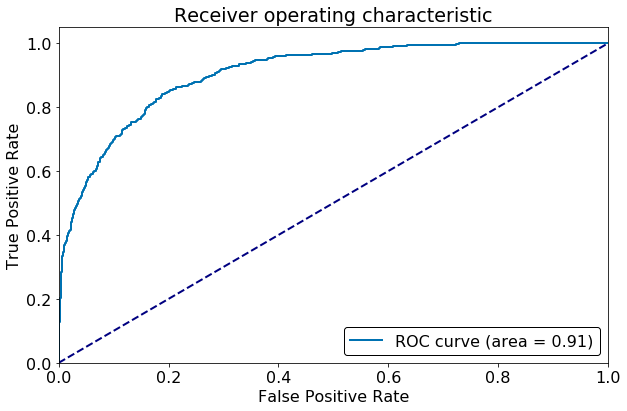

In [15]:
# prediction 
ypred = bst.predict(dval) 

fpr, tpr, _ = roc_curve(y_val, ypred)
roc_auc = auc(fpr, tpr)

plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16, 
                     'legend.framealpha':1, 
                     'legend.edgecolor':'inherit'}) 
plt.figure(figsize=(9, 6))

lw = 2
plt.plot(fpr, tpr, 
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [11]:
valid_dataset = Dataset(val_df, path)                                               
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, 
                                           batch_size=batch_size)   

model = model.eval()
for i, (images, meta_data, labels) in enumerate(valid_loader):
    images = images.to(device)

    # Forward pass
    embed = model(images)
    embedding = embed.detach().cpu().numpy()

    # determine NN features for the set of images 
    batch_features = np.concatenate((embedding, meta_data.numpy()), axis=1)
    
    # append the dataset
    try:
        Xval = np.concatenate((Xval, batch_features), 0)
        yval = np.append(yval, labels.numpy())
    except:
        Xval = batch_features 
        yval = labels.numpy() 
        
XGB_data = pd.DataFrame(data=Xval)
XGB_data['targets'] = yval 
XGB_data.to_csv("XGB_ENet_val.csv", index=False)

XGB_data = pd.read_csv("XGB_ENet_val.csv")
Xval = np.array(XGB_data.values[:, :-1], np.float32) 
yval = np.array(XGB_data['targets'].values, np.float32)

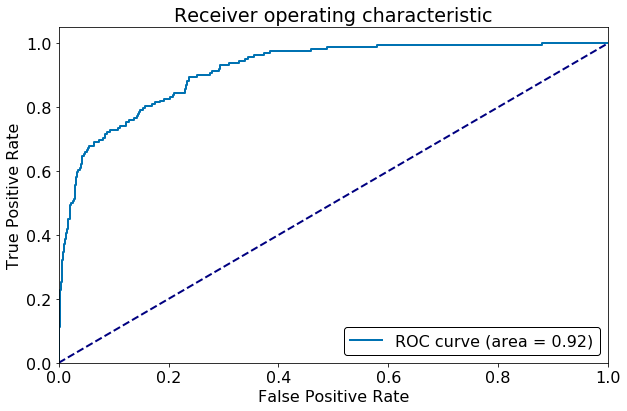

In [16]:
dtest = xgb.DMatrix(Xval)
ypred = bst.predict(dtest)

fpr, tpr, _ = roc_curve(yval, ypred)
roc_auc = auc(fpr, tpr)

plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16, 
                     'legend.framealpha':1, 
                     'legend.edgecolor':'inherit'}) 
plt.figure(figsize=(9, 6))

lw = 2
plt.plot(fpr, tpr, 
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [17]:
val_acc = accuracy_score(yval, np.round(ypred))
print("validation accuracy: {:.3f}".format(val_acc))

validation accuracy: 0.923


In [19]:
bst.save_model("../Models/xgbENet.model")